In [2]:
import dataset_flickr
import dataset_flickr7k
import helper_classes as helper
import nltk
#nltk.download('punkt')
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils import data as data
import model
import model_attention
import time 
import torch
import torch.nn as nn
import torch.optim as optim
import pathlib

import os 

In [3]:
CHECKPOINT_DIRECTORY = "model_checkpoints"

# Load Dataset

## Train set 

In [4]:
# dataset
data_args = {'stage': 'train',
            'ds_path' : "/home/Datasets/flickr30k/", 
            'captions_dir': "annotations",
            'captions_fname': 'results_new.csv',
            'images_dir': 'images_split',
            'freq_threshold': 5}
#train_data = dataset_flickr.Flickr30kData(**data_args)
train_data = dataset_flickr7k.Flickr7kData(**data_args)

print(f"Initialized {len(train_data)} images!") 

stage:  train
ds_path:  /home/Datasets/flickr30k/
captions_f:  /home/Datasets/flickr30k/annotations/results_new.csv
imgs_dir:  /home/Datasets/flickr30k/images_split/train
Initialized 7736 words in vocabulary
Initialized 35000 images!


## Validation set

In [5]:
# dataset
data_args = {'stage': 'val',
            'ds_path' : "/home/Datasets/flickr30k/", 
            'captions_dir': "annotations",
            'captions_fname': 'results_new.csv',
            'images_dir': 'images_split',
            'freq_threshold': 5}
#val_data = dataset_flickr.Flickr30kData(**data_args)
val_data = dataset_flickr7k.Flickr7kData(**data_args)

print(f"Initialized {len(val_data)} images!") 

stage:  val
ds_path:  /home/Datasets/flickr30k/
captions_f:  /home/Datasets/flickr30k/annotations/results_new.csv
imgs_dir:  /home/Datasets/flickr30k/images_split/val
Initialized 7736 words in vocabulary
Initialized 5000 images!


## Test set

In [6]:
# dataset
data_args = {'stage': 'test',
            'ds_path' : "/home/Datasets/flickr30k/", 
            'captions_dir': "annotations",
            'captions_fname': 'results_new.csv',
            'images_dir': 'images_split',
            'freq_threshold': 5}
#test_data = dataset_flickr.Flickr30kData(**data_args)
test_data = dataset_flickr7k.Flickr7kData(**data_args)

print(f"Initialized {len(test_data)} images!") 

stage:  test
ds_path:  /home/Datasets/flickr30k/
captions_f:  /home/Datasets/flickr30k/annotations/results_new.csv
imgs_dir:  /home/Datasets/flickr30k/images_split/test
Initialized 7736 words in vocabulary
Initialized 10000 images!


## Set up data loader

In [7]:
pad_idx = train_data.vocabulary.str_to_idx["<PAD>"]
batch_size = 128

train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx),
    )


val_loader = DataLoader (
        dataset=val_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx),
    )


test_loader = DataLoader(
        dataset=test_data,
        batch_size=  1,
        shuffle=True,
        #collate_fn=helper_classes.CollateCustom(pad_idx),
    )


# Set up hyperparameters

In [8]:
"""
TODO:
- need to figure out train/val batch size 
- caption length - how to set this param? 
"""
# Hyperparameters
embed_size = 256
hidden_size = 512 #256
attn_dim = 256 
vocab_size = len(train_data.vocabulary) #len(train_data.vocabulary)
num_layers = 1

learning_rate = 3e-4

# Initialize Model, Loss & optimizer

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
import importlib 
#import model_attention as model_attn
import model_attn_2 as model_attn
importlib.reload(model_attn)

<module 'model_attn_2' from '/home/INM706/INM706_CW/model_attn_2.py'>

In [11]:
model = model_attn.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, attn_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_data.vocabulary.str_to_idx["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Initialized Encoder!
Initialized Decoder!


In [12]:
idx, X, y= next(iter(train_loader))

# Train model

In [ ]:
#import pathlib
CHECKPOINT_DIRECTORY = "model_checkpoints"

model.train()

start = 1
num_epochs = 20  #60 #ONLY USE MULTIPLES OF 10 
losses = [] 
losses_val = []

time_start = time.time() 

restore_latest_checkpoint = True

if restore_latest_checkpoint:
    #find last checkpoint file based on last modified 
    all_files = pathlib.Path(CHECKPOINT_DIRECTORY).glob('*.pth')
    latest_file = max(all_files, key=os.path.getctime)
    checkpoint_file = str(latest_file).split("/")[1]
    
    #adjust epoch range
    start = int(checkpoint_file.split("_")[2]) + 1 
    num_epochs += start 
    
    #load checkpoint 
    helper.load_checkpoint(checkpoint_file, model, optimizer)

for epoch in range(start, num_epochs+1):
        
        
        
        """
        Training
        """
        batch_loss = 0 
        avg_batch_loss = 0 
        
        ####UNCOMMENT THIS 
        for batch_num, (idx, X, y) in enumerate(train_loader):

            X = X.to(device)
            y = y.to(device)

            #y_train = y.view(y.shape[1],y.shape[0])[:, :-1].to(device)
            #y_train = y.view(y.shape[1],y.shape[0]).to(device)
            y_train = y.to(device)
            
            outputs = model(X, y_train)
            
            y_target = y[:, 1:].to(device)
            
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), 
                y_target.reshape(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss += loss.item()
            
            if batch_num %100 == 0:
                print(f"batch : {batch_num}, loss : {loss.item()}")
                
                """show sample caption"""
                model.eval()
                with torch.no_grad():
                    idx, X, y= next(iter(train_loader))
                    X = X.to(device)
                    features = model.encoder(X[0:1])#.to(device)
                    plt.imshow(train_data.plot_img(idx[0]))
                    print("Expected: ", train_data.get_image_caption(idx[0]))
                    print("Predicted: ", model.generate_caption(features, train_data.vocabulary, 20))
                model.train()

        #save loss after every epoch 
        #losses.append(loss.item())
        avg_batch_loss = batch_loss/(batch_num+1)
        
            
        """
        Validation
        """
        # run validation set to see find loss 
        batch_loss_val = 0 
        avg_batch_loss_val = 0 
        with torch.no_grad(): 
            #UNCOMMENT THIS 
            for batch_num_val, (idx_val, X_val, y_val) in enumerate(val_loader):
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                
                #skip eos (?) 
                y_train_val = y_val.to(device)


                #calculate loss
                out_val = model(X_val, y_train_val)
                #skip sos for target 
                y_val_target = y_val[:, 1:].to(device)
                
                loss_val = criterion(out_val.reshape(-1, out_val.shape[2]), y_val_target.reshape(-1))
                
                batch_loss_val += loss_val.item()

        #losses_val.append(loss_val.item())#{epoch : loss_val.item()})
        avg_batch_loss_val = batch_loss_val/(batch_num_val+1)

        losses.append([avg_batch_loss, avg_batch_loss_val])
        #losses.append([loss.item(), loss_val.item()])

            
        """
        Save checkpoints
        """ 
        #save every 10 epochs
        if True: #epoch%10 == 0:
            
            
            print(f"Training loss after {epoch} epochs: {loss.item()}\nValidation loss after {epoch} epochs: {loss_val.item()}")
            print("Time elapsed: {} min".format((round((time.time()-time_start)/60, 2))))
            #save checkpoint 
            checkpoint = {"state_dict": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "step": epoch
                        }
            fname = "basic_model_" + str(epoch) + "_epochs.pth"
            
            #UNCOMMENT THIS 
            helper.save_checkpoint(checkpoint, fname)
            
            
            
                    
                
        #for final epoch 
        if epoch == num_epochs: 
            helper.save_model(model.state_dict(), "basic_model.pth")
             
print("Time elapsed for {} epochs: {} min".format(num_epochs, 
                                                  round((time.time()-time_start)/60, 2)))
print("loss: ", loss.item())

Loaded checkpoint basic_model_17_epochs.pth!
batch : 0, loss : 2.8367362022399902
Expected:  Painters on scaffolds paint the inside of a subway terminal .
Predicted:  ['a', 'man', 'in', 'a', 'white', 'shirt', 'and', 'blue', 'jeans', 'is', 'standing', 'in', 'front', 'of', 'a', 'large', 'building', '.', '<EOS>']
batch : 100, loss : 2.773405075073242
Expected:  A person wearing scuba gear is swimming underwater water .
Predicted:  ['a', 'scuba', 'diver', 'underwater', 'underwater', 'in', 'the', 'water', '.', '<EOS>']
batch : 200, loss : 2.807903289794922
Expected:  There is a football player in a red jersey on the field talking to his coach .
Predicted:  ['a', 'football', 'player', 'in', 'a', 'red', 'uniform', 'is', 'playing', 'with', 'a', 'football', 'player', 'in', 'the', 'background', '.', '<EOS>']
Training loss after 18 epochs: 2.7507948875427246
Validation loss after 18 epochs: 3.445033311843872
Time elapsed: 13.81 min
Saved checkpoint basic_model_18_epochs.pth!
batch : 0, loss : 2.7

## Plot loss 

<AxesSubplot:>

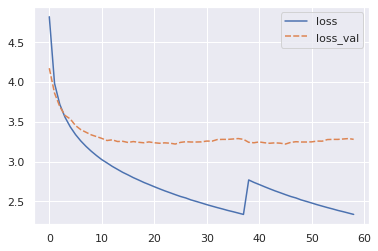

In [15]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
sns.set() 


if restore_latest_checkpoint: 
    #add to existing losses 
    old_losses = pd.read_csv('loss.csv')[["epochs", "loss", "loss_val"]]
    start_index = old_losses.epochs.max() + 1
    new_data = [[start_index+i, losses[i][0], losses[i][1]] for i in range(len(losses))]
    new_losses = pd.DataFrame(new_data, columns = ["epochs", "loss", "loss_val"])
    loss_df = pd.concat([old_losses, new_losses], keys = ["epochs", "loss", "loss_val"]).reset_index(drop = True)
    
else:
    #create new df 
    loss_df = pd.DataFrame(losses, columns = ['loss', "loss_val"])
    loss_df = loss_df.reset_index().rename(columns= {'index': 'epochs'})
    
loss_df.to_csv("loss.csv")

loss_df
sns.lineplot(data= loss_df.iloc[:, 1:])
#sns.lineplot(data = loss_df, x = "epochs", y = "loss") 

<AxesSubplot:>

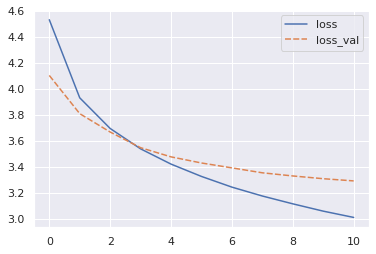

In [37]:
temp = pd.read_csv('model_checkpoints_notransforms/loss.csv')[["epochs", "loss", "loss_val"]]
sns.lineplot(data= temp.iloc[:, 1:])


## Test random cases

In [36]:
#import model 
#find last checkpoint file based on last modified 
all_files = pathlib.Path(CHECKPOINT_DIRECTORY).glob('*.pth')
latest_file = max(all_files, key=os.path.getctime)
checkpoint_file = str(latest_file).split("/")[1]

#print(checkpoint_file)

model = model_attn.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size).to(device)

path =  CHECKPOINT_DIRECTORY + "/" +  checkpoint_file
checkpoint = torch.load(path)
model.load_state_dict(checkpoint["state_dict"])

model.eval()
None

TypeError: __init__() missing 1 required positional argument: 'attn_dim'

In [77]:
#Load model for inference 
#import model
#model = model.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, extract_features).to(device)
#helper.load_model(model, "basic_model.pth")

#basic_model_170_epochs.pth

#model.eval()
#None

In [37]:
idx, X, y= next(iter(test_loader))

Expected:  There is a concert going on .
Predicted:  ['a', 'man', 'is', 'standing', 'in', 'front', 'of', 'a', 'large', 'building', 'with', 'a', 'large', 'number', 'of', '<UNK>', '.', '<EOS>']


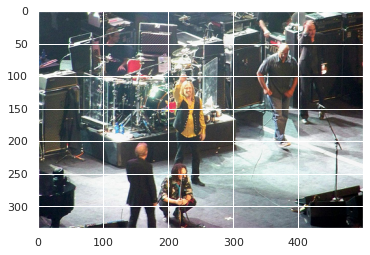

In [38]:
X = X.to(device)
features = model.encoder(X)#.to(device)
plt.imshow(test_data.plot_img(idx.item()))
print("Expected: ", test_data.get_image_caption(idx.item()))
print("Predicted: ", model.generate_caption(features, test_data.vocabulary, 20))

Expected:  A Man fixing machinery outside .
Predicted:  ['<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>']


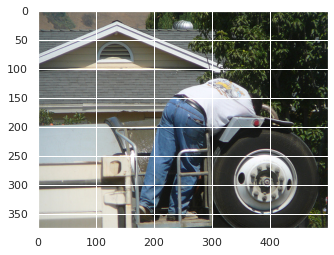

In [67]:
#train_data.plot_img(idx[0])
plt.imshow(test_data.plot_img(idx.item()))
print("Expected: ", test_data.get_image_caption(idx.item()))
print("Predicted: ", model.caption_image_greedy(X.to(device), test_data.vocabulary, 20))

In [64]:
"""
TODO: when calculating score, compare to any of the reference sentence?
"""
#print("Expected: ", train_data.get_all_captions(idx[0]))
#print("Predicted: ", model.caption_image(X[:1].to(device), train_data.vocabulary))


print("Expected: ", test_data.get_image_caption(idx.item()))
print("Predicted: ", model.caption_image_greedy(X.to(device), test_data.vocabulary, 20))

Expected:  A Man fixing machinery outside .
Predicted:  ['<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>']


In [60]:
test_data.vocabulary.str_to_idx["<EOS>"]

2

In [33]:
from PIL import Image as PILImage

fname = test_data.img_files_dict[idx.item()]
path = test_data.imgs_dir + '/' + fname 
img = PILImage.open(path).convert('RGB')

In [34]:
from torchvision import transforms as transforms

transform_train = transforms.Compose([ 
                transforms.Resize(256),                          # smaller edge of image resized to 256
               # transforms.RandomCrop(224),                      # get 224x224 crop from random location
                transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
                transforms.ToTensor(),                           # convert the PIL Image to a tensor
                transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                                     (0.229, 0.224, 0.225))
]
            )
img = transform_train(img)

In [234]:
transform = transforms.Compose([
                transforms.Resize((299, 299)),
                transforms.ToTensor()
                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
img = transform(img)

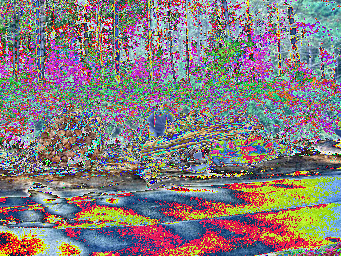

In [35]:
# define a transform to convert a tensor to PIL image
transform = transforms.ToPILImage()

# convert the tensor to PIL image using above transform
my_img= transform(img)

# display the PIL image
my_img.show()

In [ ]:
print(idx[0])
print(train_data.get_image_caption(idx[0]))
print(train_data.get_all_captions(idx[0]))
print(train_data.get_vectorized_caption(idx[0]))
train_data.plot_img(idx[0])